# Emotion Detection - JAFFE

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import losses, optimizers, metrics

## Data Processing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create the main 'data' directory
if not os.path.exists('data'):
    os.makedirs('data')

# Create 'train' and 'test' subdirectories
if not os.path.exists('data/train'):
    os.makedirs('data/train')
if not os.path.exists('data/test'):
    os.makedirs('data/test')

# Define the source directory
source_dir = '/content/drive/MyDrive/CollabData/JAFFE'

# Define the emotion labels
emotions = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']

# Create directories for each emotion within 'train' and 'test'
for emotion in emotions:
    if not os.path.exists(f'data/train/{emotion}'):
        os.makedirs(f'data/train/{emotion}')
    if not os.path.exists(f'data/test/{emotion}'):
        os.makedirs(f'data/test/{emotion}')

# List all files in the source directory
all_files = os.listdir(source_dir)

# Group files by emotion and store split files
emotion_split_files = {}
for filename in all_files:
    parts = filename.split('.')
    if len(parts) > 1:
        # The emotion seems to be the second part before the number
        # Adjust this logic if the naming convention is different
        emotion_code = parts[1][:-1] # Remove the trailing digit (e.g., 'AN1' -> 'AN')
        if emotion_code in emotions:
            if emotion_code not in emotion_split_files:
                emotion_split_files[emotion_code] = []
            emotion_split_files[emotion_code].append(filename)

# Split and copy files for each emotion
train_counts = {}
test_counts = {}
for emotion, files in emotion_split_files.items():
    if not files:
        print(f"No files found for emotion: {emotion}")
        continue

    # Split files into training and testing sets
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    train_counts[emotion] = len(train_files)
    test_counts[emotion] = len(test_files)

    # Copy training files
    for file in train_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('data/train', emotion, file)
        shutil.copy2(src_path, dest_path) # Use copy2 to preserve metadata

    # Copy testing files
    for file in test_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('data/test', emotion, file)
        shutil.copy2(src_path, dest_path)

print("Data splitting and organization complete.")
print(f"Train images per emotion: {train_counts}")
print(f"Test images per emotion: {test_counts}")

Data splitting and organization complete.
Train images per emotion: {'FE': 25, 'HA': 24, 'NE': 24, 'SA': 24, 'SU': 24, 'AN': 24, 'DI': 23}
Test images per emotion: {'FE': 7, 'HA': 7, 'NE': 6, 'SA': 7, 'SU': 6, 'AN': 6, 'DI': 6}


In [10]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

train_dir = 'data/train'
test_dir ='data/test'

img_height = 224
img_width = 224
batch_size = 32

# Function to load images as NumPy arrays
def load_images_from_directory(directory, image_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    label_map = {name: index for index, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load training and validation data
train_images, train_labels, class_names = load_images_from_directory(train_dir)
validation_images, validation_labels, _ = load_images_from_directory(test_dir)

# Convert labels to categorical
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=len(class_names))
validation_labels_one_hot = keras.utils.to_categorical(validation_labels, num_classes=len(class_names))

# Create TensorFlow datasets
train_generator = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(batch_size).shuffle(buffer_size=100)
validation_generator = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels_one_hot)).batch(batch_size)

print("Data generators created successfully.")

Data generators created successfully.


(32, 224, 224, 3)


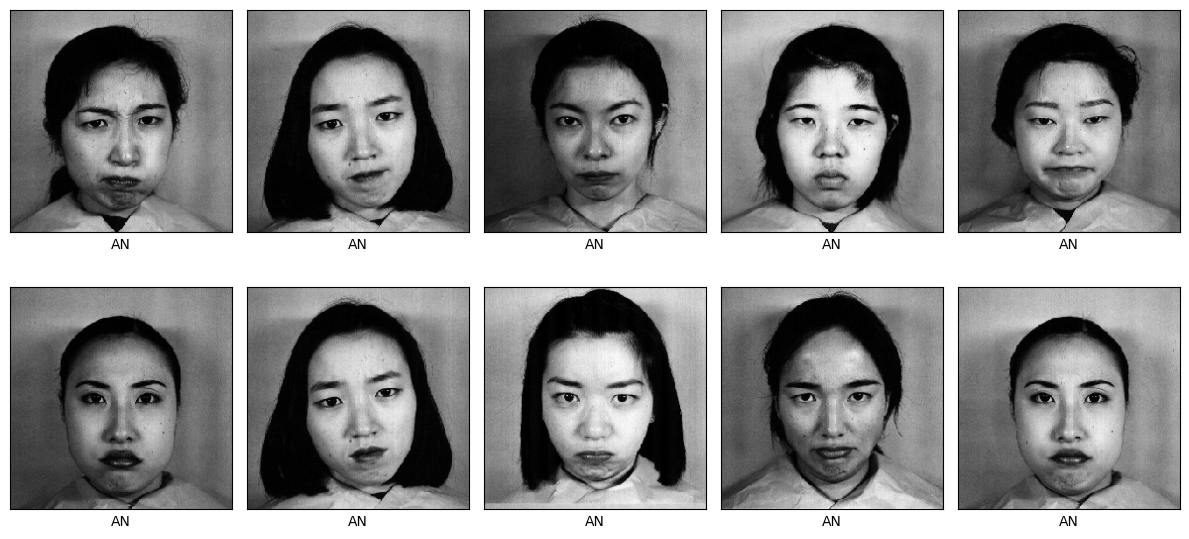

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import tensorflow

# Assuming 'train_generator' is available from your previous code setup
classes = {i: name for i, name in enumerate(class_names)}


# Use the 'train_generator' to get a batch
for images, cls_true_one_hot in train_generator.take(1): # Take one batch
    print(images.shape)
    # images and labels are already TensorFlow tensors

    # Convert one-hot encoded labels back to integer labels
    cls_true = tf.argmax(cls_true_one_hot, axis=1).numpy() # Convert to numpy array

    break # Get only the first batch for display

fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Added figsize for better display
axes = axes.flatten() # Flatten the 2x5 array of axes for easier iteration

# Get the number of images in the batch
num_images_in_batch = images.shape[0]

for i, ax in enumerate(axes): # Using 'ax' directly from flattened axes
    if i < num_images_in_batch: # Only display if there is an image in the batch
        # Plot image.
        # TensorFlow images are typically float [0, 255] or [0, 1]. Assuming [0, 255] from load_img
        img_display = images[i].numpy().astype(np.uint8) # Convert tensor to NumPy array (H, W, C) and to uint8

        ax.imshow(img_display)

        # Show true class.
        true_label_idx = cls_true[i] # Get the integer label

        # Use the 'classes' dictionary for mapping numerical label to string name
        xlabel = classes[true_label_idx]

        # Set the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Hide unused subplots
        ax.axis('off')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [25]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299), # Changed from 224 to 299
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299), # Changed from 256 to 299 (keeping aspect ratio before center crop)
        transforms.CenterCrop(299), # Changed from 224 to 299
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Model Development

In [13]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, i=0, dataloaders=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if isinstance(outputs, tuple):
                        outputs=outputs[0]

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/inception_'+str(i)+'.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning /w Covnet

Load a pretrained model and reset final fully connected layer.

In [15]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class JAFFEDataset(Dataset):
    def __init__(self, root_dir, transform=None, idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = [] # Assuming you have a way to get labels from filenames or a manifest

        # This is a simplified example; adjust based on your actual JAFFE dataset structure.
        emotion_map = {'AN': 0, 'DI': 1, 'FE': 2, 'HA': 3, 'NE': 4, 'SA': 5, 'SU': 6} # Map emotion codes to integers

        for filename in os.listdir(root_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                # Example parsing: Assuming format like 'Subj.EmotionCode.Num.ext'
                # You might need to adjust this based on your exact JAFFE file names
                parts = filename.split('.')
                if len(parts) > 1:
                    emotion_code_with_num = parts[1] # e.g., 'AN1', 'HA3'
                    emotion_code = emotion_code_with_num[:-1] # e.g., 'AN', 'HA'

                    if emotion_code in emotion_map:
                        self.image_files.append(os.path.join(root_dir, filename))
                        self.labels.append(emotion_map[emotion_code])

        if idx is not None:
            self.image_files = [self.image_files[i] for i in idx]
            self.labels = [self.labels[i] for i in idx]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB') # Ensure image is in RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
import numpy as np
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import os # Import os module

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the directory for saving models if it doesn't exist
if not os.path.exists('saved'):
    os.makedirs('saved')

dataset_sizes = {'train': len(train_images), 'val': len(validation_images)} # Using lengths from the loaded numpy arrays

accuracies = []
index = list(np.random.permutation(len(train_images) + len(validation_images))) # Use the total number of images

for i in range(10): # Assuming 10 folds
    fold_size = len(index) // 10 # Determine fold size

    # Correctly split index for train and val sets for each fold
    val_indices = index[i * fold_size:(i + 1) * fold_size]
    # Handle the last fold which might be slightly larger
    if i == 9:
        val_indices = index[i * fold_size:]

    train_indices = [idx for idx in index if idx not in val_indices]

    idx = {'val': val_indices, 'train': train_indices}

    dataloaders = {x: torch.utils.data.DataLoader(JAFFEDataset(root_dir='/content/drive/MyDrive/CollabData/JAFFE', transform=data_transforms[x], idx=idx[x]), batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}


    # Recalculate dataset_sizes for the current fold
    dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

    model_ft = models.inception_v3(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # Assuming class_names is defined

    # InceptionV3 also has an auxiliary classifier
    num_aux_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_aux_ftrs, len(class_names))

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)
    writer = SummaryWriter('./logs/inception_full') # Consider adding fold index to log path
    model_ft, best_acc  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, i, dataloaders,
                           num_epochs=20)
    # Assuming best_acc is a tensor, convert it to a Python float
    accuracies.append(float(best_acc.cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

# After the loop, you can calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"\nAverage accuracy across 10 folds: {average_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedul

Epoch 0/19
----------


100%|██████████| 12/12 [03:14<00:00, 16.23s/it]


train Loss: 2.0145 Acc: 0.1458


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 2.0286 Acc: 0.0952

Epoch 1/19
----------


 42%|████▏     | 5/12 [01:20<01:51, 15.99s/it]